<a target="_blank" href="https://colab.research.google.com/github/cboettig/rl-minicourse/blob/main/challenge.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

#  Conservation Gym Testbed

In this example, we set up a generic three species, two action problem, and illustrate how to provide a custom population dynamics function, action function, and utility function to represent a caribou conservation objective.  

In [ ]:
# we'll need these packages to begin
!pip install stable-baselines3 plotnine polars sb3_contrib tensorboard


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # change to -1 if you want to use CPU

## Caribou Conservation

We consider a scenario where wolves, $Z$, prey on both caribou, $Y$ and elk, $X$, while caribou and elk compete for resources:

$$X_{t+1} = X_t + r_x X \left( 1 -  \frac{X +\tau_{xy} Y}{K} \right) - \frac{(1-D) \beta Z X^2}{v_0^2 + X^2} + \sigma_x X \xi_x$$

$$Y_{t+1} = Y_t + r_y Y \left( 1 - \frac{Y +\tau_{yx} X}{K} \right) - \frac{D \beta Z X^2}{v_0^2 + Y^2} + \sigma_y Y \xi_y$$

$$Z_{t+1} = Z_t + \alpha \beta Z \left( \frac{(1-D) X^2}{v_0^2 + X^2}  +  \frac{D Y^2}{v_0^2 + Y^2}  \right) - d_H Z + \sigma_z Z \xi_z$$

In [3]:
import numpy as np
# pop = elk, caribou, wolves
# Caribou Scenario
def dynamics(pop, effort, harvest_fn, p, timestep=1):

    pop = harvest_fn(pop, effort)        
    X, Y, Z = pop[0], pop[1], pop[2]
    
    K = p["K"] # - 0.2 * np.sin(2 * np.pi * timestep / 3200)
    D = p["D"] + 0.5 * np.sin(2 * np.pi * timestep / 3200)
    beta = p["beta"] + 0.2 * np.sin(2 * np.pi * timestep / 3200)

    X += (p["r_x"] * X * (1 - (X + p["tau_xy"] * Y) / K)
            - (1 - D) * beta * Z * (X**2) / (p["v0"]**2 + X**2)
            + p["sigma_x"] * X * np.random.normal()
            )
    
    Y += (p["r_y"] * Y * (1 - (Y + p["tau_yx"]* X ) / K )
            - D * beta * Z * (Y**2) / (p["v0"]**2 + Y**2)
            + p["sigma_y"] * Y * np.random.normal()
            )

    Z += p["alpha"] * beta * Z * (
            (1-D) * (X**2) / (p["v0"]**2 + X**2)
            + D * (Y**2) / (p["v0"]**2 + Y**2)
            ) - p["dH"] * Z +  p["sigma_z"] * Z  * np.random.normal()
    
    pop = np.array([X, Y, Z], dtype=np.float32)
    pop = np.clip(pop, [0,0,0], [np.Inf, np.Inf, np.Inf])
    return(pop)


In [4]:

initial_pop = [0.5, 0.5, 0.2]


parameters = {
"r_x": np.float32(0.13),
"r_y": np.float32(0.2),
"K": np.float32(1),
"beta": np.float32(.1),
"v0":  np.float32(0.1),
"D": np.float32(0.8),
"tau_yx": np.float32(0.7),
"tau_xy": np.float32(0.2),
"alpha": np.float32(.4), 
"dH": np.float32(0.03),
"sigma_x": np.float32(0.05),
"sigma_y": np.float32(0.05),
"sigma_z": np.float32(0.05)
}


We must also define the dynamics of the action, a 'harvest' or culling function.  In this scenario, we imagine that we can cull either the elk or wolf population (or both).  We assume our control action introduces a percent mortality equal to the control effort applied times a catachability coefficient:

In [5]:
def harvest(pop, effort):
    q0 = 0.5 # catchability coefficients -- erradication is impossible
    q2 = 0.5
    pop[0] = pop[0] * (1 - effort[0] * q0) # pop 0, elk
    pop[2] = pop[2] * (1 - effort[1] * q2) # pop 2, wolves
    return pop


Lastly, we need to define the utility or reward derived from taking these actions under this population state.  In this scenario, our population control actions are costly, while we acrue a benefit proportional to the size of the current caribou population:

In [6]:
def utility(pop, effort):
    benefits = 0.5 * pop[1] # benefit from Caribou
    costs = .00001 * (effort[0] + effort[1]) # cost to culling
    if np.any(pop <= 0.01):
        benefits -= 1
    return benefits - costs




To simulate our environment and allow RL algorithms to train on this environment, we define a simple python class using the gym module.  This class defines the possible action space as two continuously-valued action variables (culling effort of elk and wolves respectively), and three continuously valued state variables (population of elk, caribou and wolves).  To improve performance of RL training, it is necessary to transform the continuous space to -1, 1

In [7]:
import gymnasium as gym

class s3a2(gym.Env):
    """A 3-species ecosystem model with two control actions"""
    def __init__(self, config=None):
        config = config or {}
                                
        ## these parameters may be specified in config                                  
        self.Tmax = config.get("Tmax", 800)
        self.threshold = config.get("threshold", np.float32(1e-4))
        self.init_sigma = config.get("init_sigma", np.float32(1e-3))
        self.training = config.get("training", True)
        self.initial_pop = config.get("initial_pop", initial_pop)
        self.parameters = config.get("parameters", parameters)
        self.dynamics = config.get("dynamics", dynamics)
        self.harvest = config.get("harvest", harvest)
        self.utility = config.get("utility", utility)
        self.observe = config.get("observe", lambda state: state) # default to perfectly observed case
        self.bound = 2 * self.parameters["K"]
        
        self.action_space = gym.spaces.Box(
            np.array([-1, -1], dtype=np.float32),
            np.array([1, 1], dtype=np.float32),
            dtype = np.float32
        )
        self.observation_space = gym.spaces.Box(
            np.array([-1, -1, -1], dtype=np.float32),
            np.array([1, 1, 1], dtype=np.float32),
            dtype=np.float32,
        )        
        self.reset(seed=config.get("seed", None))


    def reset(self, *, seed=None, options=None):
        self.timestep = 0
        self.initial_pop += np.multiply(self.initial_pop, np.float32(self.init_sigma * np.random.normal(size=3)))
        self.state = self.state_units(self.initial_pop)
        info = {}
        return self.observe(self.state), info


    def step(self, action):
        action = np.clip(action, self.action_space.low, self.action_space.high)
        pop = self.population_units(self.state) # current state in natural units
        effort = (action + 1.) / 2

        # harvest and recruitment
        reward = self.utility(pop, effort)
        nextpop = self.dynamics(pop, effort, self.harvest, self.parameters, self.timestep)
        
        self.timestep += 1
        terminated = bool(self.timestep > self.Tmax)
        
        # in training mode only: punish for population collapse
        if any(pop <= self.threshold) and self.training:
            terminated = True
            reward -= 50/self.timestep
        
        self.state = self.state_units(nextpop) # transform into [-1, 1] space
        observation = self.observe(self.state) # same as self.state
        return observation, reward, terminated, False, {}
    
    def state_units(self, pop):
        self.state = 2 * pop / self.bound - 1
        self.state = np.clip(self.state,  
                             np.repeat(-1, self.state.__len__()), 
                             np.repeat(1, self.state.__len__()))
        return np.float32(self.state)
    
    def population_units(self, state):
        pop = (state + 1) * self.bound /2
        return np.clip(pop, 
                       np.repeat(0, pop.__len__()),
                       np.repeat(np.Inf, pop.__len__()))
    
# verify that the environment is defined correctly    
from stable_baselines3.common.env_checker import check_env
env = s3a2()
check_env(env, warn=True)    


In [8]:
action = np.array([-1,-1])
action = np.array([-.7,-.97])

df = []
episode_reward = 0
observation, _ = env.reset()
for t in range(env.Tmax):
  obs = env.population_units(observation) # natural units
  df.append([t, episode_reward, *obs])
  observation, reward, terminated, done, info = env.step(action)
  episode_reward += reward
#  if terminated or done:
#    break

episode_reward


59.63384205549128

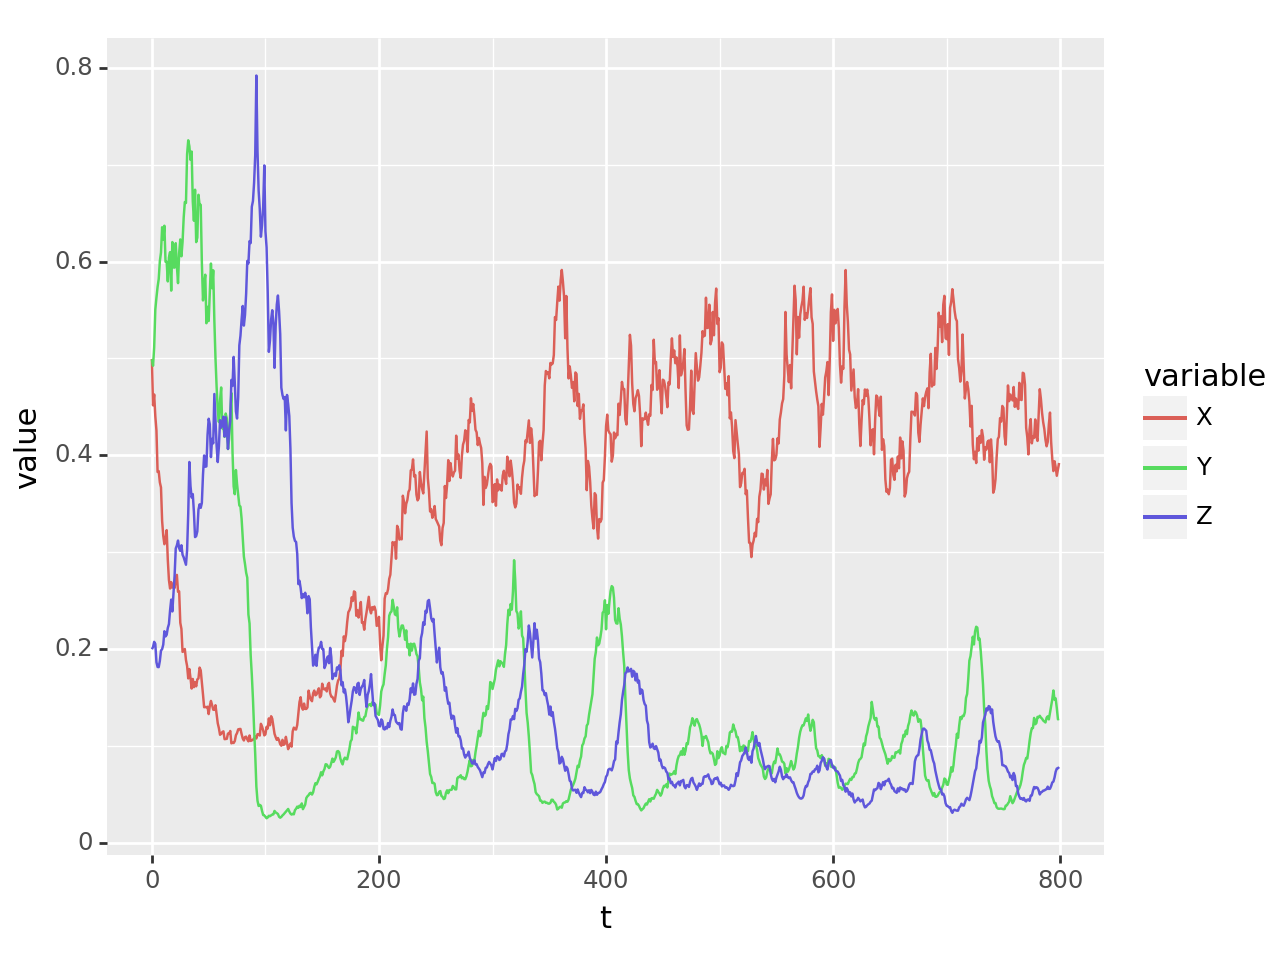

<Figure Size: (640 x 480)>

In [9]:

import polars as pl
from plotnine import ggplot, aes, geom_line
cols = ["t", "reward", "X", "Y", "Z"]

dfl = (pl.DataFrame(df, schema=cols).
        select(["t", "X", "Y", "Z"]).
        melt("t")
      )
ggplot(dfl, aes("t", "value", color="variable")) + geom_line()



## RL Agents

In [10]:
from sb3_contrib import TQC, ARS
from stable_baselines3 import PPO, A2C, DQN, SAC, TD3
from stable_baselines3.common.env_util import make_vec_env
vec_env = make_vec_env(s3a2, 12)


In [11]:
# Let's set a tensorboard to watch the progress of training before we begin.
%load_ext tensorboard
%tensorboard --logdir ./logs

In [12]:
model = ARS("MlpPolicy", vec_env, verbose=0, tensorboard_log="logs")
model.learn(total_timesteps=2_000_000)
model.save("ars_caribou_C")


In [13]:

model = PPO("MlpPolicy", vec_env, verbose=0, tensorboard_log="logs", use_sde=True)
model.learn(total_timesteps=2_000_000)
model.save("ppo_caribou_C")

In [14]:

model = PPO("MlpPolicy", env)
agent = model.load("ppo_caribou_C")
df = []
episode_reward = 0
observation, _ = env.reset()
for t in range(env.Tmax):
  action, _ = agent.predict(observation, deterministic=True)
  obs = env.population_units(observation) # natural units
  effort = (action + 1)/2
  df.append([t, episode_reward, *effort, *obs])
  
  observation, reward, terminated, done, info = env.step(action)
  episode_reward += reward
  if terminated or done:
    break

episode_reward

322.4448450176195

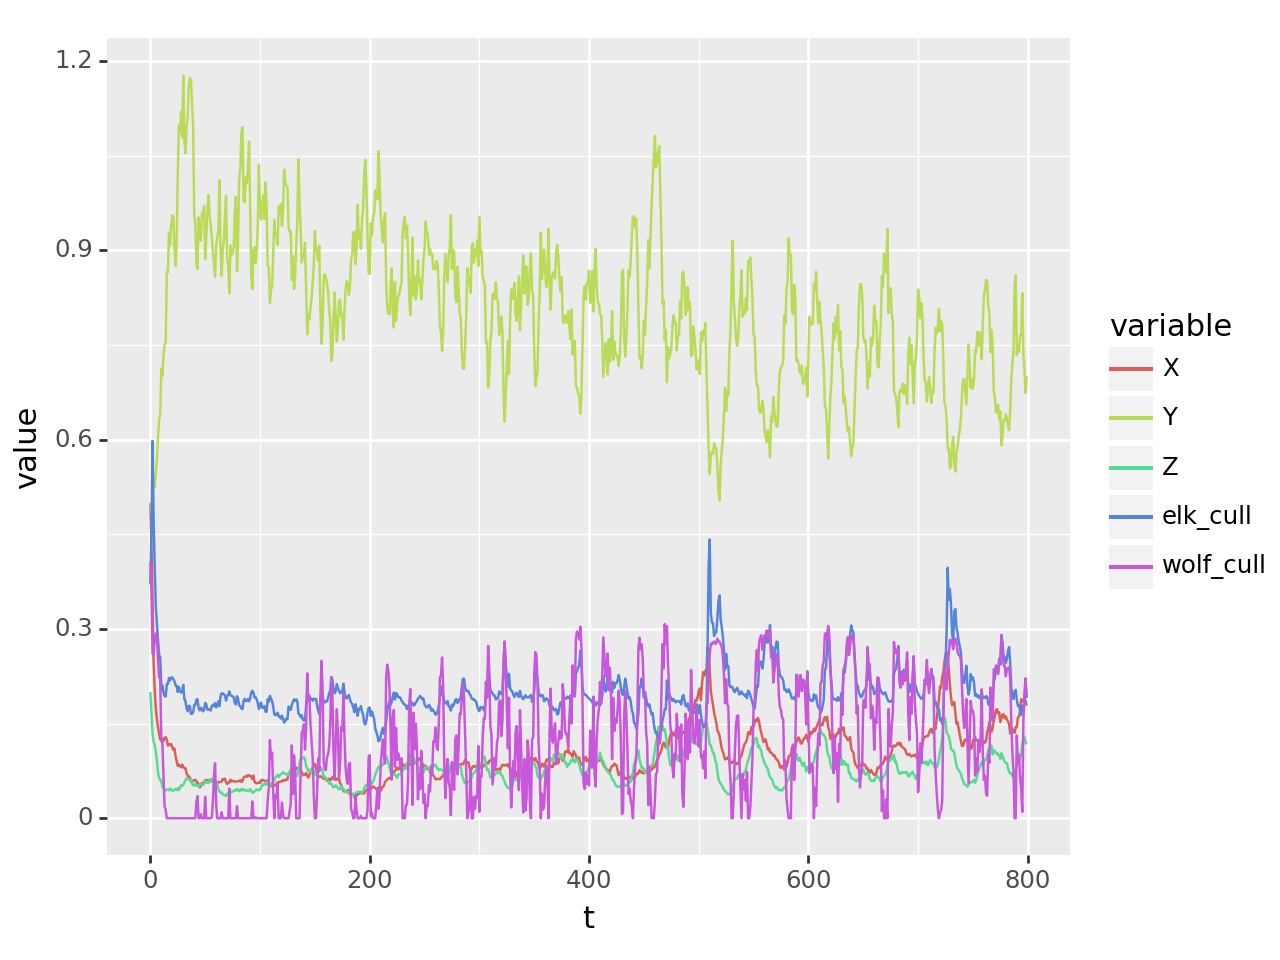

<Figure Size: (640 x 480)>

In [15]:

# optional plotting code
import polars as pl
from plotnine import ggplot, aes, geom_line
cols = ["t", "reward", "elk_cull", "wolf_cull", "X", "Y", "Z"]

dfl = (pl.DataFrame(df, schema=cols).
        select(["t", "elk_cull", "wolf_cull", "X", "Y", "Z"]).
        melt("t")
      )
ggplot(dfl, aes("t", "value", color="variable")) + geom_line()

In [16]:
model = TQC("MlpPolicy", env, verbose=0, tensorboard_log="logs", use_sde=True)
model.learn(total_timesteps=1_000_000)
model.save("tqc_caribou_C")

In [18]:

model = TQC("MlpPolicy", env)
agent = model.load("tqc_caribou_C")
df = []
episode_reward = 0
observation, _ = env.reset()
for t in range(env.Tmax):
  action, _ = agent.predict(observation, deterministic=True)
  obs = env.population_units(observation) # natural units
  effort = (action + 1)/2
  df.append(np.append(np.append([t, episode_reward], effort), obs))
  
  observation, reward, terminated, done, info = env.step(action)
  episode_reward += reward
  if terminated or done:
    break

episode_reward

367.59745755654114

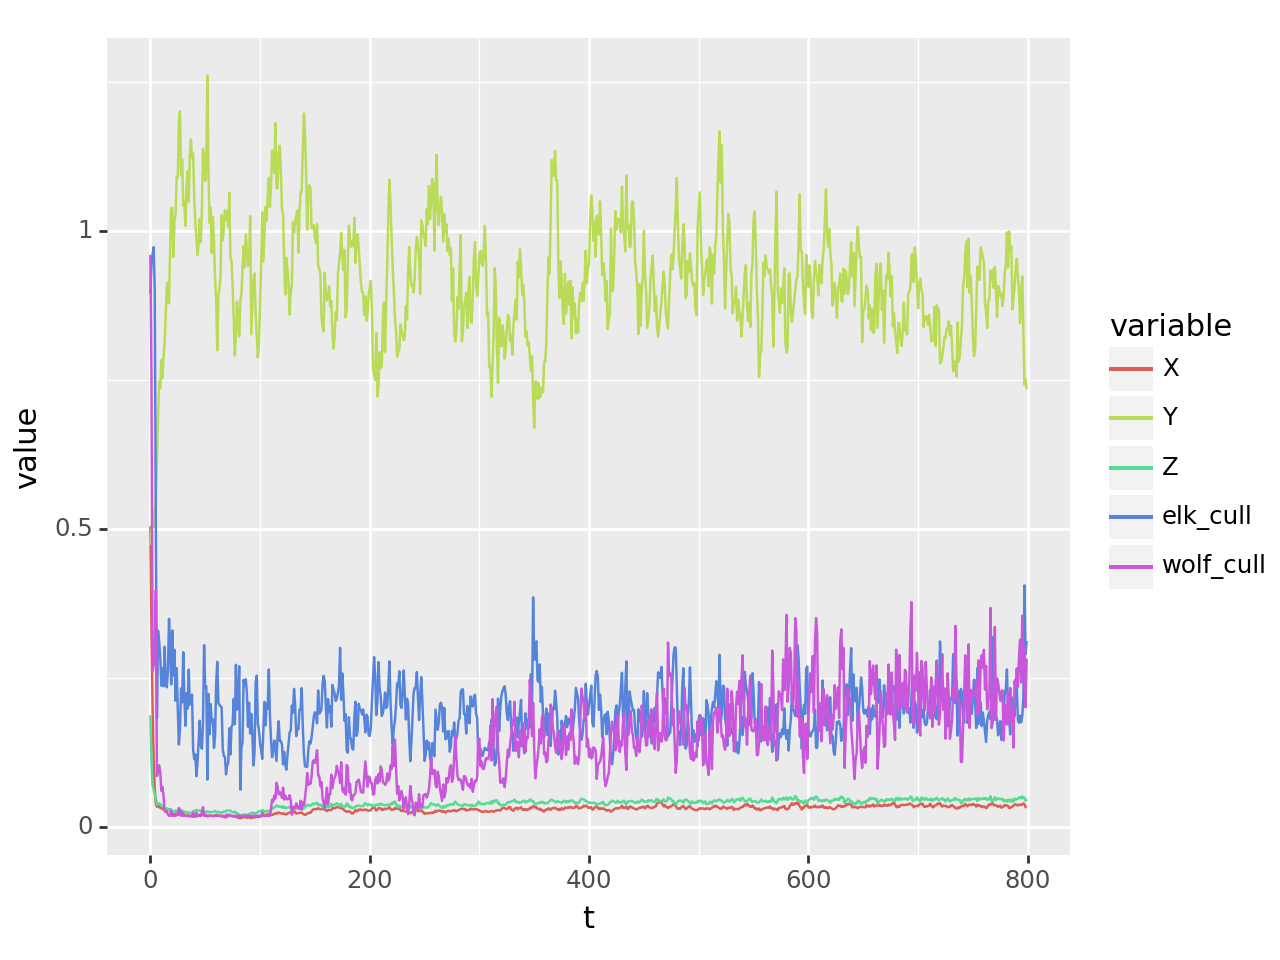

<Figure Size: (640 x 480)>

In [19]:
import polars as pl
from plotnine import ggplot, aes, geom_line
cols = ["t", "reward", "elk_cull", "wolf_cull", "X", "Y", "Z"]

dfl = (pl.DataFrame(df, schema=cols).
        select(["t", "elk_cull", "wolf_cull", "X", "Y", "Z"]).
        melt("t")
      )
ggplot(dfl, aes("t", "value", color="variable")) + geom_line()